# Блендинг и Стэкинг

<font size="5"> Смесь экспертов</font>

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/weighted_voting.png" width="450"></center>

Первый подход — берем много предсказаний большого количества моделей и усредняем (считаем, что модели равноправны).

$$\large h(x) = \dfrac 1 k \sum_{i=i}^k  a_i (x) $$
Потом задумываемся о том, что каждая модель предсказывает в целом по-разному. Одна модель ошибается в $10\%$ случаев, другая — в $15\%$ и так далее. Было бы неплохо к предсказаниям этих моделей подобрать веса. Так рождается идея того же бустинга.

$$\large h(x) = \sum_{i=i}^k b_i a_i (x) $$


Следующий логичный шаг — подумать о том, что каждая модель может ошибаться на каких-то своих объектах. Например, при предсказании, насколько велика вероятность, что человек серьезно заболеет, одна модель будет плохо работать для европейцев, а другая — для жителей Новой Гвинеи.

$$\large h(x) = \sum_{i=i}^k b_i(x) a_i (x) $$

Получается ситуация, в которой то, насколько хорошо будет предсказывать модель, зависит от самого объекта. Фактически это означает то, что мы бы хотели для каждого объекта получать какой-то вектор весов, а дальше суммировать предсказания моделей $a_i$, используя эти веса.





Как получать эти веса для каждого объекта?
Обучим еще одну модель, которая явно или неявно предсказывает веса алгоритмов и агрегирует их предсказания. Называться она будет **мета-алгоритмом**.

Обычно в качестве мета-алгоритма используются сравнительно простые модели, например, линейные.

Как получить такую модель? Есть два распространенных подхода — **stacking** и **blending**

## Blending (Блендинг)

На соревновании Netflix Prize была поставлена задача — предсказать, как люди оценят тот или иной фильм.
Победил подход, основанный на таком объединении моделей, при котором у вас каждая модель получает вес в зависимости от объекта. Подход называется **блендинг**.

Отличительной особенностью такого способа ансамблирования является использование моделей разной природы.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L03/netflix_prize.png" width="600"/></center>

<center><em>Source: <a href="https://amatria.in/blog/on-the-usefulness-of-the-netflix-prize-403d360aaf2/">On the “Usefulness” of the Netflix Prize</a></em></center>

Разберем пошагово, как реализуется блендинг:
1. Делим данные на подвыборки. Обучающая выборка состоит из двух подвыборок — одна для обучения ансамбля алгоритмов (чаще это выборка побольше), другая для обучения мета-алгоритма.
2. Обучаем ансамбль на первой выборке.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/split_data_blending.png" width="850"></center>

3. Получаем предсказания ансамбля на объектах второй выборки.
4. Используем эти предсказания как признаки для обучения мета-алгоритма.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/train_meta_blending.png" width="1000"></center>

5. Получаем предсказания на тестовой выборке.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/test_predict_blending.png" width="850"></center>

Недостатком блендинга является то, что мы дополнительно разбиваем обучающую выборку, так как нельзя учить и базовые алгоритмы, и мета-алгоритм на одних и тех же данных.

Для улучшения качества можно сделать несколько блендингов (по-разному разбивая обучающую выборку на подвыборки), а дальше усреднять предсказания разных блендингов.

Попробуем сделать простой блендинг

In [1]:
class BlendingRegressor:
    def __init__(self, first_layer_models, second_layer_model):
        self.first_layer_models = {
            name: sklearn.clone(model) for name, model in first_layer_models.items()
        }
        self.second_layer_model = sklearn.clone(second_layer_model)

    def fit_1st_layer(self, x, y):
        for name, model in self.first_layer_models.items():
            print(f"Fitting {name}")
            model.fit(x, y)

    def predict_1st_layer(self, x):
        features = np.zeros((x.shape[0], len(self.first_layer_models)))
        for ind, model in enumerate(self.first_layer_models.values()):
            features[:, ind] = model.predict(x)
        return features

    def fit_2nd_layer(self, x, y):
        features = self.predict_1st_layer(x)
        self.second_layer_model.fit(features, y)

    def predict(self, x):
        features = self.predict_1st_layer(x)
        y_pred = self.second_layer_model.predict(features)
        return y_pred

In [2]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split


calif_housing = sklearn.datasets.fetch_california_housing(as_frame=True)
x = calif_housing["data"].values
y = calif_housing["target"].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [3]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.3 MB/s eta 0:00:00


In [4]:
from sklearn.utils import resample
import numpy as np

def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)

    for sample in range(samples_cnt):
        x_boot, y_boot = resample(x, y, replace=True, n_samples=x.shape[0])
        b_metric[sample] = metric_fn(x_boot, y_boot)

    return b_metric

In [5]:
from sklearn.metrics import mean_squared_error

def train_and_test_regressor(models, x_train, y_train, x_test, y_test, verb=True):
    boot_scores = {}
    for name, model in models.items():
        model.fit(x_train, y_train)  # train the model
        y_pred = model.predict(x_test)  # get predictions
        boot_scores[name] = bootstrap_metric(  # calculate bootstrap score
            y_test,
            y_pred,
            metric_fn=mean_squared_error,
        )
        if verb:
            print(f"Fitted {name} with bootstrap score {boot_scores[name].mean():.3f}")

    results = pd.DataFrame(boot_scores)

    return results


In [6]:
import catboost
import pandas as pd

models_add = {}
models_add["CatBoost"] = catboost.CatBoostRegressor(
    iterations=2000,
    learning_rate=0.1,
    random_state=42,
    verbose=0,
    )

cat_add = train_and_test_regressor(models_add, x_train, y_train, x_test, y_test)

Fitted CatBoost with bootstrap score 0.188


In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm


first_layer_models = {}

first_layer_models["LinReg"] = make_pipeline(
    StandardScaler(with_mean=False), LinearRegression()
)

first_layer_models["RF"] = RandomForestRegressor(
    n_estimators=250, max_depth=None, min_samples_leaf=1, n_jobs=-1, random_state=42
)

first_layer_models["XGB"] = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    min_child_weight=13,
    n_jobs=-1,
    objective="reg:squarederror",
)

first_layer_models["LGBM"] = lightgbm.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=12,
    random_state=42,
    min_child_weight=13,
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1,
)

first_layer_models["CatBoost"] = catboost.CatBoostRegressor(
    iterations=2000,
    verbose=0,
    learning_rate=0.1,
    depth=5,
    random_state=42,
    min_data_in_leaf=5,
)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
x_learn, x_valid, y_learn, y_valid = train_test_split(x_train, y_train, random_state=42)
blend_reg = BlendingRegressor(first_layer_models, LinearRegression())

blend_reg.fit_1st_layer(x_learn, y_learn)
blend_reg.fit_2nd_layer(x_valid, y_valid)
y_pred = blend_reg.predict(x_test)
blend_boot = bootstrap_metric(y_test, y_pred, metric_fn=mean_squared_error)

Fitting LinReg
Fitting RF
Fitting XGB
Fitting LGBM
Fitting CatBoost


In [9]:
import pandas as pd

blend_data = pd.DataFrame({"SingleBlending": blend_boot})

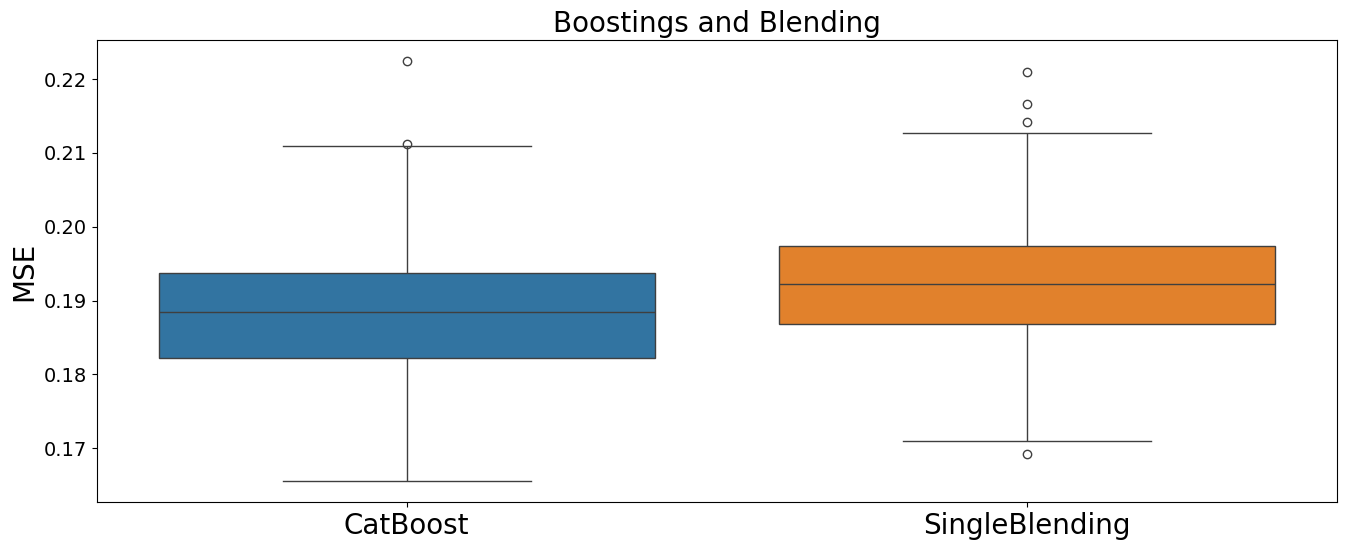

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=pd.concat([cat_add, blend_data]))
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boostings and Blending", size=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=20)
plt.show()

Одиночный блендинг работает даже хуже, чем один CatBoost.

Попробуем обучить 10 блендингов с разными разбиениями `x_train` на `x_learn` и `x_valid`:

In [11]:
from IPython.display import clear_output

blending_ensemble = []

# takes some time to run
for i in range(1, 11):
    print(f"Training blending {i}")
    x_learn, x_valid, y_learn, y_valid = train_test_split(
        x_train, y_train, random_state=i * 7 % 13
    )
    blend_reg = BlendingRegressor(first_layer_models, LinearRegression())

    blend_reg.fit_1st_layer(x_learn, y_learn)
    blend_reg.fit_2nd_layer(x_valid, y_valid)
    blending_ensemble.append(blend_reg)
    clear_output()

In [12]:
y_pred = 0
for blend_reg in blending_ensemble:
    y_pred += blend_reg.predict(x_test)
y_pred /= len(blending_ensemble)


eblend_boot = bootstrap_metric(y_test, y_pred, metric_fn=mean_squared_error)
eblend_data = pd.DataFrame({"EnsembleBlending": eblend_boot})

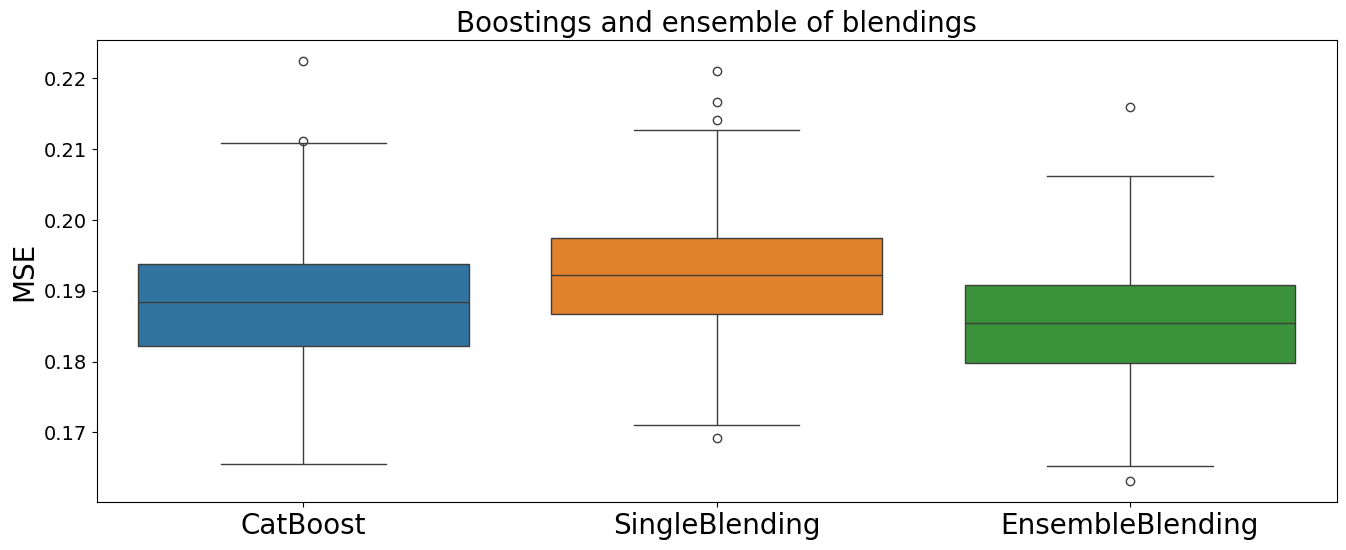

In [13]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=pd.concat([cat_add, blend_data, eblend_data]))

plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boostings and ensemble of blendings", size=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=20)
plt.show()

Качество по сравнению с лучшей моделью (CatBoost) существенно не отличается.

## Стэкинг

Также можно использовать другой способ, который позволяет использовать всю обучающую выборку.

Вместо того, чтобы делить обучающую выборку на подвыборки, давайте использовать кросс-валидацию.

Для этого:
1. Делим обучающий набор на блоки.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/split_data_stacking.png" width="800"></center>

2. Обучаем базовую модель из ансамбля на каждом кросс-валидационном разбиении.

 На блоке, который не вошел в обучение, делаем предсказание. Получаем предсказания для всех объектов обучающей выборки. Повторяем процедуру для каждой модели в ансамбле.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/cv_train_stacking.png" width="800"></center>


3. Обучаем мета-алгоритм на полученных признаках.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/train_meta_stacking.png" width="500"></center>


4. Для предсказания на тестовых данных ансамбль базовых алгоритмов переучивается на всей тренировочной выборке.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/all_train_stacking.png" width="500"></center>

5. Используем этот ансамбль для получения признаков для предсказания мета-алгоритма

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/test_predict_stacking.png" width="1000"></center>

Стэкинг, в отличие от блендинга, использует всю тренировочную выборку.

Но этим мы вносим несколько проблем, одной из которых является то, что ансамбль, на предсказаниях которого мы учили мета-алгоритм, и ансамбль, предсказания которого мы в итоге используем, немного отличаются.

Такой подход более склонен к переобучению. Для борьбы с ним можно, к примеру, подмешивать к предсказаниям базовых моделей шум.

Также, по причине того, что нам надо делать предсказание на кросс-валидации, работать этот метод будет дольше, чем Blending.

В sklearn уже реализован свой `StackingRegressor`, поэтому в этой лекции мы его реализовывать не будем.

Можете посмотреть пример реализации, например, [здесь 🐾[git]](https://github.com/Dyakonov/ml_hacks/blob/master/dj_stacking.ipynb). Если вам действительно понадобится стэкинг, полезно иметь свою собственную реализацию, чтобы легко менять в ней некоторые детали (вариантов стекинга великое множество).

Возьмем в нашу новую модель только быстро обучащиеся модели

In [14]:
base_models = []

base_models.append(
    ["LinReg", make_pipeline(StandardScaler(with_mean=False), LinearRegression())]
)

base_models.append(
    [
        "XGB",
        xgboost.XGBRegressor(
            n_estimators=500,
            learning_rate=0.1,
            max_depth=5,
            random_state=42,
            min_child_weight=13,
            n_jobs=-1,
            objective="reg:squarederror",
        ),
    ]
)

base_models.append(
    [
        "LGBM",
        lightgbm.LGBMRegressor(
            n_estimators=2000,
            learning_rate=0.1,
            max_depth=-1,
            num_leaves=12,
            random_state=42,
            min_child_weight=13,
            n_jobs=-1,
            verbose=-1,
        ),
    ]
)

base_models.append(
    [
        "CatBoost",
        catboost.CatBoostRegressor(
            iterations=2000,
            verbose=0,
            learning_rate=0.1,
            depth=5,
            random_state=42,
            min_data_in_leaf=5,
        ),
    ]
)

In [15]:
from sklearn.ensemble import StackingRegressor


stacking_reg = StackingRegressor(base_models, LinearRegression(), cv=3)
stacking_reg.fit(x_train, y_train)

StackingRegressor(cv=3,
                  estimators=[['LinReg',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler(with_mean=False)),
                                               ('linearregression',
                                                LinearRegression())])],
                              ['XGB',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,...
                                            min_child_weight=13, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...)],
                              ['LGBM',
                               LGBMRegressor(min_child_weight=13,
                                             n_estimators=2000, n_jobs=-1,
                                             num_leaves=12, random_state=42,
                                             verbose=-1)],
                              ['CatBoost',
                               <catboost.core.CatBoostRegressor object at 0x79f8d80f50f0>]],
                  final_estimator=LinearRegression())

In [16]:
y_pred = stacking_reg.predict(x_test)

stack_boot = bootstrap_metric(y_test, y_pred, metric_fn=mean_squared_error)

stack_data = pd.DataFrame({"Stacking": stack_boot})

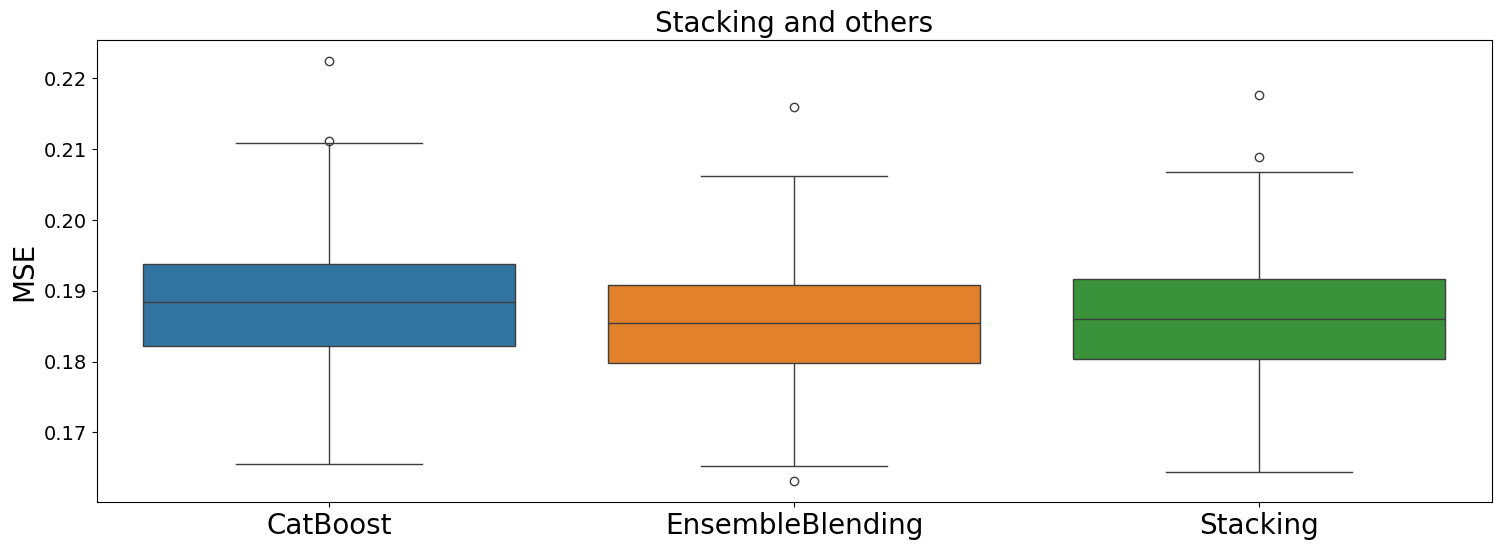

In [17]:
plt.figure(figsize=(18, 6))
ax = sns.boxplot(
    data=pd.concat([cat_add, eblend_data, stack_data])
)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Stacking and others", size=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=20)
plt.show()

Видим, что стэкинг в данной задаче не принес существенного улучшения. Однако, такие техники часто используют на соревнованиях, чтобы получить максимальное качество предсказания.